# Volume 4: Inverted Pendulum
    Benj McMullin
    Math 439
    4/4/2024

In [1]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import linalg as la

# Problem 1

Write a function that returns the matrices A, B, Q, and R given above. Let
g = 9.8 m/s
2
.

In [2]:
def linearized_init(M, m, l, q1, q2, q3, q4, r):
    '''
    Parameters:
    ----------
    M, m: floats
          masses of the rickshaw and the present
    l   : float
          length of the rod
    q1, q2, q3, q4, r : floats
        relative weights of the position and velocity of the rickshaw, the
        angular displacement theta and the change in theta, and the control


    Return
    -------
    A : ndarray of shape (4,4)
    B : ndarray of shape (4,1)
    Q : ndarray of shape (4,4)
    R : ndarray of shape (1,1)
    '''
    g = 9.8
    
    # Find everything
    A = np.array([[0,1,0,0],
                 [0,0,m*g/M,0],
                 [0,0,0,1],
                 [0,0,g/(M*l)*(M+m),0]])
    
    B = np.array([[0],[1/M],[0],[1/(M*l)]])
    Q = np.diag([q1,q2,q3,q4])
    R = np.array([[r]])
    
    return A,B,Q,R

# Problem 2

Write the following function to find the matrix $P$ using `scipy.optimize.root`.
Since root takes in a vector and not a matrix, you will have to reshape the matrix P before
passing it in and after getting your result, using `np.reshape(16)` and `np.reshape((4,4))`.

In [3]:
def find_P(A,B,Q,R):
    '''
    Parameters:
    ----------
    A, Q : ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    
    Returns
    -------
    P : the matrix solution of the Riccati equation
    '''
    # Function to find the root of
    def f(p):
        p = p.reshape((4,4))                           # Reshape the input vector into a 4x4 matrix
        P = p @ A + A.T @ p + Q - p @ B @ np.linalg.inv(R) @ B.T @ p   # Calculate the matrix equation
        return P.reshape(16)                           # Reshape the resulting matrix into a vector

    # Initial guess for the root
    P0 = np.ones((4,4))                               # Initialize an array of ones in a 4x4 matrix
    P = root(f, P0).x                                  # Find the root using the initial guess

    return P.reshape((4,4))                            # Reshape the resulting vector back into a 4x4 matrix and return it


In [4]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.

# Linearize to find P
# Assign values returned from linearized_init function to A, B, Q, R
A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
# Find P using the linearized system
P = find_P(A, B, Q, R)

# Eigenvalues
# Compute the eigenvalues and eigenvectors of the matrix A - B @ inv(R) @ B.T @ P
eigs, eigvecs = np.linalg.eig(A - B @ np.linalg.inv(R) @ B.T @ P)
print("Eigenvalues:")
print(eigs)  # Print the eigenvalues
print("Any eigenvalue greater than 0:", np.any(eigs > 0))  # Check if any eigenvalue is greater than 0

Eigenvalues:
[-1.72875212+0.j         -0.07538846+0.07490226j -0.07538846-0.07490226j
  1.72530814+0.j        ]
Any eigenvalue greater than 0: True


# Problem 3
 
Write the following function that implements the LQR solution described earlier.
Use `scipy.integrate.solve_ivp` to solve the IVP.

In [5]:
def rickshaw(tv, X0, A, B, Q, R, P, t_space = None):
    '''
    Parameters:
    ----------
    tv : tuple containing start and stop times (t0,tf) that can be passed into solve_ivp
    X0 : Initial conditions on state variables
    A, Q: ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    P : ndarray of shape (4,4)
    Returns
    -------
    Z : ndarray of shape (n+1,4), the state vector at each time
    U : ndarray of shape (n+1,), the control values
    '''
    def ode(t, z):
        """Define the Ordinary Differential Equation (ODE) system"""
        # Calculate the derivative of the state vector z using the linearized dynamics
        return (A - B @ np.linalg.inv(R) @ B.T @ P) @ z

    # Solve the system of ODEs
    # Call solve_ivp function with the defined ODE function, initial time, initial state vector, and time points to evaluate
    if t_space is None:
        sol = solve_ivp(ode, (tv[0],tv[-1]), X0, t_eval=tv)
    elif t_space is not None:
        sol = solve_ivp(ode, tv, X0, t_eval=t_space)

    # Calculate the control input U
    # Control input is calculated using the formula U = -inv(R) @ B.T @ P @ sol.y
    U = -np.linalg.inv(R) @ B.T @ P @ sol.y

    # Return the solution trajectory, control inputs, and time points
    return sol.y, U.flatten(), sol.t


# Problem 4

Test the function made in Problem (3). Find the matrix $P$ using the `scipy.optimize.root` method and plot with `tf=6` as well as the `solve_continuous_are`
method and plot with `tf=60`. Plot the solutions $\tilde{z}$ and $\tilde{u}$. Compare your results to Figure
21.3.

In [6]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.
tf = 6
X0 = np.array([-1, -1, .1, -.2])

# Define time points to evaluate
# Create a linearly spaced array of time points from 0 to tf with 200 points
tv = np.linspace(0, tf, 200)

# Find the optimal P matrix using the find_P function
P = find_P(A, B, Q, R)

# Call the rickshaw function to solve the system
# Pass the time points, initial state vector X0, system matrices A, B, Q, R, and the calculated P matrix
Z, U, t = rickshaw(tv, X0, A, B, Q, R, P)

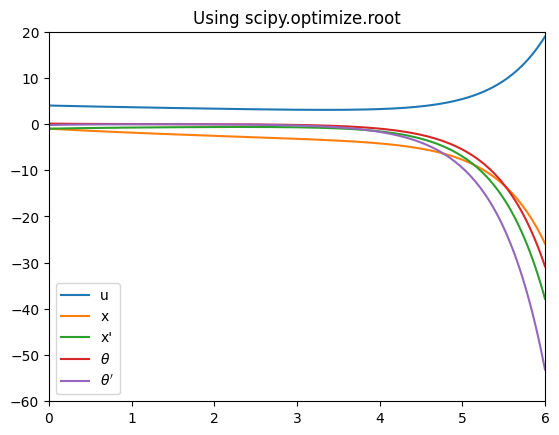

In [7]:
# Plot it
plt.plot(t,U, label='u')
plt.plot(t,Z[0], label='x')
plt.plot(t,Z[1], label="x'")
plt.plot(t,Z[2], label=r"$\theta$")
plt.plot(t,Z[3], label=r"$\theta'$")
plt.title("Using scipy.optimize.root")
plt.xlim(0,6)
plt.ylim(-60,20)
plt.legend()
plt.show()

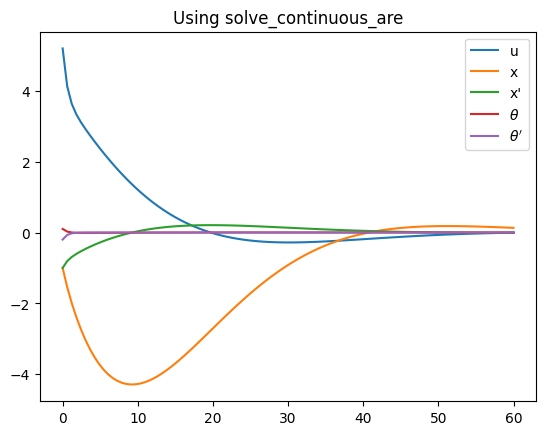

In [8]:
# Solve with solve_continuous_are
P = la.solve_continuous_are(A,B,Q,R)
tf = 60
tv = np.linspace(0,tf,100)

Z,U,t = rickshaw(tv,X0,A,B,Q,R,P)

# Plot it
plt.plot(t,U, label='u')
plt.plot(t,Z[0], label='x')
plt.plot(t,Z[1], label="x'")
plt.plot(t,Z[2], label=r"$\theta$")
plt.plot(t,Z[3], label=r"$\theta'$")
plt.title("Using solve_continuous_are")
plt.legend()
plt.show()

u_copy = U.copy()
t_copy = t.copy()

# Problem 5
Use the control $\tilde{u}$ that you found in problem 4 to solve the nonlinear equation

$\ddot x = \frac{u+m\sin\theta(-l\dot \theta^2+g\cos\theta)}{l(M+m(1-\cos^2\theta))}$,


$\ddot{\theta} = \frac{g(m+M)\sin\theta+\cos\theta(u-lm\dot\theta^2\sin\theta)}{M+m(1-\cos^2\theta)}$.

In [14]:
def nonlinear_ode(t, y, u):
    '''
    You're welcome.
    y[0] -- x
    y[1] -- x prime
    y[2] -- theta
    y[3] -- theta prime
    '''
    G = 9.8
    return np.array([
        y[1],
        (u(t) + m * np.sin(y[2]) * (G * np.cos(y[2]) - l * y[3] ** 2)) / (m + M - m * np.cos(y[2]) ** 2),
        y[3],
        (G * (m + M) * np.sin(y[2]) + np.cos(y[2]) * (u(t) - l * m * y[3] ** 2 * np.sin(y[2]))) / (l * (m + M - m * np.cos(y[2]) ** 2))
    ])

def five():
    part_space = np.geomspace(1, 61, 120) - 1

    M, m = 23., 5.
    l = 4.
    q1, q2, q3, q4 = 1., 1., 1., 1.
    r = 10.
    tf = None
    X0 = np.array([-1, -1, .1, -.2])
    # tv = np.linspace(0, tf, 200)

    # Find the optimal P matrix using the find_P function
    A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
    P = find_P(A, B, Q, R)

    x = np.array([])
    x_dot = np.array([])
    theta = np.array([])
    theta_dot = np.array([])
    u_vals = np.array([])
    t_vals = np.array([])

    for i in range(len(part_space) - 1):

        t = np.linspace(part_space[i], part_space[i+1], 3)
        t_vals = np.append(t_vals, t)

        # tv = np.linspace(part_space[i], part_space[i+1], 100)

        Z, u, t1 = rickshaw((part_space[i], part_space[i+1]), X0, A, B, Q, R, P, t_space = t)

        u1 = CubicSpline(t, u)

        z = solve_ivp(nonlinear_ode, (part_space[i], part_space[i+1]), X0, t_eval=t, args=(u1,)).y

        x = np.append(x, z[0])
        x_dot = np.append(x_dot, z[1])
        theta = np.append(theta, z[2])
        theta_dot = np.append(theta_dot, z[3])
        u_vals = np.append(u_vals, u)

        X0 = z[:,-1].copy()

    return x, x_dot, theta, theta_dot, u_vals, t_vals

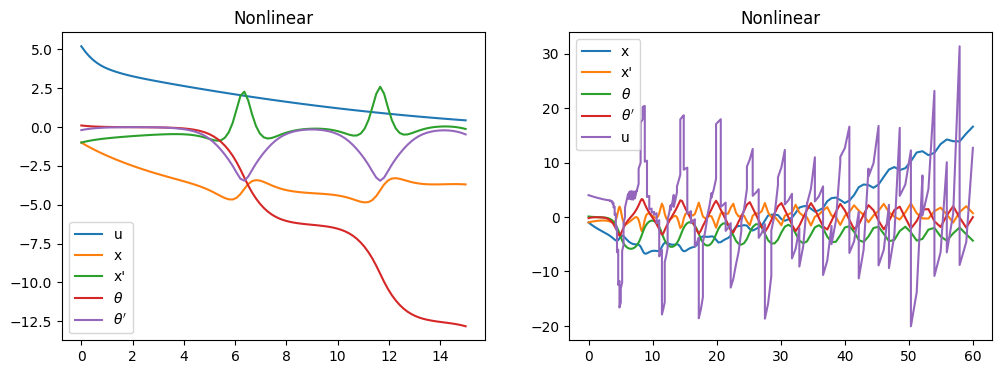

In [15]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.
tf = None
X0 = np.array([-1, -1, .1, -.2])
tv = np.linspace(0, 15, 100)

P = find_P(A, B, Q, R)

Z, U, t = rickshaw(tv, X0, A, B, Q, R, P)
u = CubicSpline(t_copy.copy(), u_copy.copy())

sol = solve_ivp(nonlinear_ode, (0, 15), X0, t_eval=tv, args=(u,))
Z = sol.y
t = sol.t

fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
ax[0].plot(t,u(t), label='u')
ax[0].plot(t, Z[0], label='x')
ax[0].plot(t, Z[1], label="x'")
ax[0].plot(t, Z[2], label=r"$\theta$")
ax[0].plot(t, Z[3], label=r"$\theta'$")
ax[0].set_title("Nonlinear")
ax[0].legend()

x, x_dot, theta, theta_dot, u_vals, t_vals = five()
x_for_plot = np.linspace(0, 60, len(x))
ax[1].plot(t_vals, x, label='x')
ax[1].plot(t_vals, x_dot, label="x'")
ax[1].plot(t_vals, theta, label=r"$\theta$")
ax[1].plot(t_vals, theta_dot, label=r"$\theta'$")
ax[1].plot(t_vals, u_vals, label='u')
ax[1].set_title("Nonlinear")
ax[1].legend()

plt.show()